In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import linprog
from random import randrange

# Data for final consumption and total output

## Final consumption

In [2]:
fdata = pd.read_csv('fdata_deu.csv', sep = ',')
fdata.head()

,Unnamed: 0,f,fmin,fmax,f.maxF,f.maxX
0,A01,21457.851487,0,19312.930956,19312.930956,19312.930956
1,A02,3034.759567,0,2731.283611,2.427354,2.427354
2,A03,366.298763,0,329.668887,329.668887,329.668887
3,B,11531.103621,0,10378.720960,5458.072038,5458.072038
4,C10-C12,180232.806666,0,162262.891729,162262.891729,162262.891729


In [3]:
f = fdata.iloc[:,1].astype('float')
f_max = np.array(fdata.iloc[:,3].astype('float'))
f_max
f.shape

(55,)

## Total output

In [4]:
xdata =  pd.read_csv('xdata_deu.csv', sep = ',')
xdata.tail()   

,Unnamed: 0,x,xmin,xmax,x.maxF,x.maxX
50,O84,326446.9910,0,326446.991000,306201.098420,306201.098420
51,P85,205736.8240,0,205736.824000,200894.751180,200894.751180
52,Q,381918.5085,0,381918.508500,380852.716052,380852.716052
53,R_S,195188.5340,0,75740.830036,75740.830036,75740.830036
54,T,9955.7790,0,9955.779000,9955.778971,9955.778971


In [5]:
x = xdata.iloc[:,1].astype('float')
x_max = np.array(xdata.iloc[:,3].astype('float'))

In [6]:
supply_shock = np.zeros(x_max.shape[0])
for i in range (0,x_max.shape[0]):
    supply_shock[i] = round(1- x_max[i]/x[i],6)
    
supply_shock = np.array(supply_shock)

# IO table 

In [7]:
df = pd.read_csv('deu_wiot.csv',sep = ',',low_memory=False)
df.head()

,Unnamed: 0,A01,A02,A03,B,C10-C12,C13-C15,C16,C17,C18,...,M71,M72,M73,M74_M75,N,O84,P85,Q,R_S,T
0,A01,4.164926e-02,0.022453,0.000046,0.000532,0.145642,2.236215e-03,1.373681e-04,9.344121e-05,3.726292e-05,...,0.000016,0.000169,0.000017,0.000188,0.001027,1.571802e-03,0.000152,0.000999,0.000331,0
1,A02,7.900009e-04,0.148384,0.000043,0.001372,0.000066,3.458867e-05,5.639422e-02,2.235241e-03,1.798931e-05,...,0.000065,0.000010,0.000031,0.000017,0.000071,2.544306e-05,0.000011,0.000018,0.000128,0
2,A03,4.366784e-07,0.000000,0.012957,0.000002,0.000357,2.755762e-07,1.188522e-07,4.207657e-07,5.563061e-07,...,0.000000,0.000000,0.000000,0.000000,0.000000,8.194973e-07,0.000000,0.000017,0.000004,0
3,B,2.219650e-04,0.000084,0.000116,0.002035,0.000291,2.382501e-04,2.586815e-04,3.853536e-04,1.026987e-04,...,0.000133,0.000099,0.000066,0.000086,0.000063,1.312530e-04,0.000043,0.000079,0.000068,0
4,C10-C12,6.141175e-02,0.000821,0.001096,0.001411,0.128738,2.820159e-03,1.333614e-03,1.250540e-03,9.674707e-04,...,0.000423,0.001414,0.000287,0.000705,0.000292,7.647949e-03,0.001857,0.019801,0.001344,0


In [8]:
df = df.iloc[:,1:]# leaving out industries U and T
df = df.astype('float')
df.shape

(55, 55)

In [9]:
A = np.array(df)
N = A.shape[0]
A.shape

(55, 55)

## Matrix Z

In [10]:
df_Z = pd.read_csv('Zmatrix_deu.csv', sep=',', low_memory=False)
df_Z =  df_Z.iloc[:,1:]# leaving out industries U and T
df_Z = df_Z.astype('float')
df_Z.shape

(55, 55)

In [11]:
Z = np.array(df_Z)
N = Z.shape[0]
Z.shape

(55, 55)

In [12]:
x_0 = np.array(x)
x_0.shape

(55,)

In [13]:
f_0 = np.array(f)
f_0.shape

(55,)

In [14]:
L = np.linalg.inv(np.identity(N)-A)
L.shape

(55, 55)

# Models

In [15]:
def max_output(N,L,A,xmax,fmax):
    z = np.ones(N)
    obj = -np.matmul(np.matrix.transpose(z), L)
    lhs_ineq = np.concatenate((-L,L))
    rhs_ineq = np.concatenate((np.zeros(N), xmax))
    
    bnd = []
    for i in range (0,N):
        bnd.append((0,fmax[i]))
    
    result = linprog(c = obj, A_ub= lhs_ineq, b_ub= rhs_ineq, bounds = bnd)
    
    optimal_output = -result.fun
    
    optimal_f = np.ones(N)
    for i in range(0,N):
        optimal_f[i] = result.x[i]
    
    return optimal_output, optimal_output/sum(x_0), sum(optimal_f)/sum(f_0)

In [16]:
def max_consumption(N,L,A,xmax,fmax):
    z = np.ones(N)
    obj2 = -np.matmul(np.matrix.transpose(z), np.identity(N)-A)
    lhs_ineq2 = np.concatenate((-(np.identity(N)-A), np.identity(N)-A))
    rhs_ineq2 = np.concatenate((np.zeros(N), fmax))
    
    bnd2 = []
    for i in range (0,N):
        bnd2.append((0,xmax[i]))
        
    result2 = linprog(c = obj2, A_ub= lhs_ineq2, b_ub= rhs_ineq2, bounds= bnd2)
    optimal_f_2 = -result2.fun
    
    optimal_output_2 = np.ones(N)
    for i in range(0,N):
        optimal_output_2[i] = round(result2.x[i])
        
    return result2.success, sum(optimal_output_2)/sum(x_0), optimal_f_2/sum(f_0)

In [17]:
N= 54
f_max = f_max[:N]
x_max = x_max[:N]
A = A[:N,:N]
Z = Z[:N,:N]
x_0 = x_0[:N]
f_0 = f_0[:N]
L = np.linalg.inv(np.identity(N)-A)
supply_shock = np.array(supply_shock[:N])

In [18]:
def algo_proportional(A, L, fmax, xmax, TT, prioritize="no"):
    x = [0]
    fvec = []          # initial demand vector
    fvec.append(fmax)
    r = [0]            # output constraints
    s = [0]            # input bottlenecks 
    d = [0]            # aggregated demand vector 
    d.append(np.matmul(L, fvec[0])) #d[1] = L*f[0]

    list_ = [1] 
    t=1
    epsilon = 1e-6
    while not np.all(abs(d[t] - d[t-1]) < epsilon) and t<TT:
        #print('\nIteration {0}'.format(t))
        #print('---------')
        #print('Initial aggregated demand: {}'.format(d[t]))
        r.append(np.ones(len(xmax)))
        s.append(np.ones(len(xmax)))
        fvec.append(np.ones(len(xmax)))
        x.append(np.ones(len(xmax)))
        d.append(np.ones(len(xmax)))
        
        ##########################################
        ########### Output constraints ###########
        ##########################################
        for i in range (0,len(x_max)):
            r[t][i] = xmax[i]/d[t][i]
        #print('Output constraints:{}'.format(r[t]))
        
        ##########################################
        ########### Input bottlenecks ############
        ##########################################
        for i in range(0,len(x_max)):
            for j in range(0,len(x_max)):
                if A[j][i] > 0:
                    list_.append(r[t][j])
            s[t][i] = min(list_)
            list_ = [1]
        #print('Input bottlenecks:{}'.format(s[t]))
        
        ##############################################
        ########### Constrained Production ###########
        ##############################################
        for i in range(0,len(xmax)):
            x[t][i] = min(xmax[i], s[t][i]*d[t][i])
        #print('Constrained production:{}'.format(x[t]))
        
        ##############################################
        ############ Constrained Delivery ############
        ##############################################
        for i in range(0,len(xmax)):
            fvec[t][i] = max(x[t][i] - np.matmul(A[i],x[t]),0)
        #print('Constrained delivery:{}'.format(fvec[t]))
        
        ###############################################
        ############ New Aggregated Demand ############
        ###############################################
        for i in range(0,len(xmax)):
            d[t+1][i] = np.matmul(L[i],fvec[t])
        t=t+1
        #print('Aggregated Demand:         {}'.format(d[t]))
        if t == TT:
            print("Algoritm did not converge")
            
    return sum(x[t-1]), sum(x[t-1])/sum(x_0), sum(fvec[t-1])/sum(f_0), t


In [19]:
def algo_mixed(A, L, fmax, xmax, TT,prioritize="yes"):
    x = [0]
    fvec = [] # initial demand vector
    fvec.append(fmax)
    r = [0]   # output constraints
    s = [0]   # input bottlenecks 
    d = [0]   # aggregated demand vector 
    d.append(np.matmul(L, fvec[0])) #d[1] = L*f[0]
    
    list_ = [1] 
    t=1
    epsilon = 1e-6
    while not np.all(abs(d[t] - d[t-1]) < epsilon) and t<TT:
        #print('\nIteration {0}'.format(t))
        #print('---------')
        #print('Initial aggregated demand: {}'.format(d[t]))
        r.append(np.ones(len(xmax)))
        s.append(np.ones(len(xmax)))
        fvec.append(np.ones(len(xmax)))
        x.append(np.ones(len(xmax)))
        d.append(np.ones(len(xmax)))
        
        ##########################################
        ########### Output constraints ###########
        ##########################################
        for i in range (0,len(x_max)):
            r[t][i] = xmax[i]/np.matmul(A[i],d[t])
        #print('Output constraints:         {}'.format(r[t]))
        
        ##########################################
        ########### Input bottlenecks ############
        ##########################################
        for i in range(0,len(x_max)):
            for j in range(0,len(x_max)):
                if A[j][i] > 0:
                    list_.append(r[t][j])
            s[t][i] = min(list_)
            list_ = [1]
        #print('Input bottlenecks:         {}'.format(s[t]))
        
        ##############################################
        ########### Constrained Production ###########
        ##############################################
        for i in range(0,len(xmax)):
            x[t][i] = min(xmax[i], s[t][i]*d[t][i])
            #print(s[t][i]*d[t][i])
        
        ##############################################
        ############ Constrained Delivery ############
        ##############################################
        for i in range(0,len(xmax)):
            #print(np.matmul(A[i],s[t]*d[t]))
            fvec[t][i] = max(x[t][i] - np.matmul(A[i],x[t]),0) 
        #print('Constrained delivery:      {}'.format(fvec[t]))
        
        ###############################################
        ############ New Aggregated Demand ############
        ###############################################
        for i in range(0,len(xmax)):
            d[t+1][i] = np.matmul(L[i],fvec[t])
        t=t+1
    
    if t == TT:
        print("Algoritm did not converge")
        
    return sum(x[t-1]), sum(x[t-1])/sum(x_0), sum(fvec[t-1])/sum(f_0), t

In [20]:
def order(A, L, fmax):
    d = np.matmul(L, fmax)
    list_1 = []      # list we will sort
    list_2 = []      # list that will not be sorted to find the original indices
    for i in range(A.shape[0]):
        list_1.append([])
        list_2.append([])
    for i in range(A.shape[0]):
        for j in range(A.shape[0]):
            list_1[i].append(A[i][j]*d[j])    # list_1[i][j] = list_2[i][j] = A[i][j]*d[j]
            list_2[i].append(A[i][j]*d[j])
        list_1[i].sort(reverse = True)        # we sort list_1: A[i][j]*d[j] >= A[i][j+1]*d[j+1]

    names_ordered=[]
    for i in range(A.shape[0]):
        names_ordered.append([])
    
    for i in range(A.shape[0]):
        for k in list_1[i]:                  # we take the indices of the j+1 (j from 0 to N-1) biggest suppliers of industry i. 
                for l in range(A.shape[0]):    
                    if list_2[i][l] == k:
                        names_ordered[i].append(l)   
    return names_ordered

In [21]:
def algo_priority(A, L, fmax, xmax, ordered, TT= 30, prioritize="yes"):          
    x = [0]
    fvec = []   # initial demand vector
    fvec.append(fmax)
    rvec = [0]  # output constraints
    s = [0]     # input bottlenecks 
    d = [0]     # aggregated demand vector 
    d.append(np.matmul(L, fvec[0])) #d[1] = L*f[0]
    
    list_ = [1] 
    t=1
    epsilon = 1e-6
    
    while not np.all(abs(d[t] - d[t-1]) < epsilon) and t<TT:
        #print('\nIteration {0}'.format(t))
        #print('---------')
        #print('Initial aggregated demand: {}'.format(d[t]))
        rvec.append([np.zeros(N)])
        s.append(np.ones(N))
        fvec.append(np.ones(N))
        x.append(np.ones(N))
        d.append(np.ones(N))
        demand = np.identity(N)
        
        som = 0
        for i in range(0,N):
            for j in range(0,N):
                for k in ordered[i][:j+1]:
                    som = som + A[i][k]*d[t][k] 
                demand[i][j] = som   #demand[i][j] = demand of j'th biggest customers of firm i summed up
                som = 0
        remainder = np.identity(N)
    
        for i in range(0,N):
            for j in range(0,N):
                remainder[i][j] = xmax[i] - demand[i][j]
                
        ####################################################
        ####################### rvec #######################
        ####################################################
        for i in range(0,N):
            rvec[t].append([])
        for i in range(0,N):
            if all(remainder[i][j]>0 for j in range(0,N)):
                rvec[t][i] = np.ones(N) 
            elif all(remainder[i][j]<=0 for j in range(0,N)): 
                rvec[t][i] = np.zeros(N)
                for k in ordered[i][:1]: 
                    rvec[t][i][k] = xmax[i]/demand[i][0]
        
            else: 
                idx = np.where(remainder[i]<=0) # index for partially met demand
                idx_fully = np.where(remainder[i]>0) 
                length = len(idx_fully[0])
                rvec[t][i] = np.zeros(N)
                for l in range(0,length-1):
                    index = ordered[i][l]
                    rvec[t][i][index] = 1
                m = ordered[i][length-1]
                rvec[t][i][m] = remainder[i][length-1]/(demand[i][length]-demand[i][length-1])
          
        #####################################################
        ################# Input bottlenecks #################
        #####################################################
        for i in range(0,N):
            for j in range(0,N):
                if A[j][i]>0:
                    list_.append(rvec[t][j][i])
            s[t][i] = min(list_)
            list_ = [1]   
        #print('Input bottlenecks:         {}'.format(s[t]))
        
        ######################################################
        ############### Constrained Production ###############
        ######################################################
        for i in range(0,N):
            x[t][i] = min(xmax[i], s[t][i]*d[t][i])
       
        ######################################################
        ################ Constrained Delivery ################
        ######################################################
        for i in range(0,len(xmax)):
            fvec[t][i] = max(x[t][i] - np.matmul(A[i],x[t]),0)
        
        ######################################################
        ################ Aggregated demand ###################
        ######################################################
        for i in range(0,len(xmax)):
            d[t+1][i] = np.matmul(L[i],fvec[t])
            
        t=t+1
        if t==TT:
            print("Algorithm did not converge")
            
    return sum(x[t-1]), sum(x[t-1])/sum(x_0), sum(fvec[t-1])/sum(f_0), t

In [22]:
def algo_random(A, L, fmax, xmax, runs, prioritize = "random"):
    som_x = []
    x = []
    y = []
    TT = 30
    while len(x)<runs:
        random_ordered=[]
        for i in range(N):
            random_ordered.append([])
    
        for i in range(N):
            while len(random_ordered[i])<N:
                random = randrange(N)
                while random in random_ordered[i]:
                    random = randrange(N)# we willen nu de indices van de j+1 (j van 0 tot en met N-1) grootste suppliers  
                random_ordered[i].append(random)
                
        result = algo_priority(A, L, fmax, xmax, random_ordered, TT, prioritize="yes")
        if result[3] != TT:
            som_x.append(result[0])
            x.append(result[1])
            y.append(result[2])
    return sum(som_x)/len(som_x), sum(x)/len(x), sum(y)/len(y)

# Effect Network Density

### Eliminate Ranom Links

In [23]:
def eliminate_rand(A, x, f, desired_density):
    Anew = A
    zeros = np.sum(Anew==0)
    Znew = Z
    indices_x = []
    indices_y = []
    if desired_density != 1:
        sparselink = round((N**2)*(1-desired_density) - np.sum(Anew==0)) # number of links we need to remove to get desired density
        print("Sparselink: {0}".format(sparselink))
        while(np.sum(Znew==0)) < sparselink + zeros: 
            random_x = randrange(N)
            random_y = randrange(N)
            while Znew[random_x,random_y] == 0:
                random_x = randrange(N)
                random_y = randrange(N)
            Znew[random_x, random_y] = 0  
            
    xnew = np.sum(Znew, axis=1) + f
    for i in range(0,N):
        for j in range(0,N):
            Anew[i][j] = Znew[i][j]/x[j]
    Lnew = np.linalg.inv(np.identity(N)-Anew)
    #xnew = Znew + f
    
    return xnew, Anew, Lnew, Znew

## Direct shock

**For 50 different densities, we adapt our matrix. We compute xnew, Anew, xmaxnew. Then we apply the shocks to the new data: instead of sum(xmax)/sum(x) it is now equal to sum(xmaxnew)/sum(xnew).**

In [24]:
resdir_x = np.identity(50)
densseq = np.linspace(0,1,50)
runs_dens = 50
for i in range(len(densseq)):
    print("Itaration {0}" .format(i))
    for j in range(runs_dens):
        A = np.array(df)[:N,:N] 
        Z = np.array(df_Z)[:N,:N] 
        newdat = eliminate_rand(A, x_0, f_0, densseq[i])
        xmaxnew = np.ones(N)
        for k in range(0,N):
            xmaxnew[k] = newdat[0][k]*(1- supply_shock[k])
        resdir_x[i][j] = (sum(xmaxnew)/sum(newdat[0]))
resdir_x = np.mean(resdir_x, axis = 1)

Itaration 0
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Itaration 1
Sparselink: 2833
Sparselink: 2833
Sparselink: 2833
Sparselink: 2833
Sparselink: 2833
Sparselink: 2833
Sparselink: 2833
Sparsel

Sparselink: 2357
Sparselink: 2357
Sparselink: 2357
Sparselink: 2357
Sparselink: 2357
Sparselink: 2357
Sparselink: 2357
Sparselink: 2357
Sparselink: 2357
Sparselink: 2357
Sparselink: 2357
Sparselink: 2357
Sparselink: 2357
Sparselink: 2357
Sparselink: 2357
Sparselink: 2357
Sparselink: 2357
Sparselink: 2357
Sparselink: 2357
Sparselink: 2357
Sparselink: 2357
Itaration 10
Sparselink: 2298
Sparselink: 2298
Sparselink: 2298
Sparselink: 2298
Sparselink: 2298
Sparselink: 2298
Sparselink: 2298
Sparselink: 2298
Sparselink: 2298
Sparselink: 2298
Sparselink: 2298
Sparselink: 2298
Sparselink: 2298
Sparselink: 2298
Sparselink: 2298
Sparselink: 2298
Sparselink: 2298
Sparselink: 2298
Sparselink: 2298
Sparselink: 2298
Sparselink: 2298
Sparselink: 2298
Sparselink: 2298
Sparselink: 2298
Sparselink: 2298
Sparselink: 2298
Sparselink: 2298
Sparselink: 2298
Sparselink: 2298
Sparselink: 2298
Sparselink: 2298
Sparselink: 2298
Sparselink: 2298
Sparselink: 2298
Sparselink: 2298
Sparselink: 2298
Sparselink: 2298
S

Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Itaration 20
Sparselink: 1703
Sparselink: 1703
Sparselink: 1703
Sparselink: 1703
Sparselink: 1703
Sparselink: 1703
Sparselink: 1703
Sparselink: 1703
Sparselink: 1703
Sparselink: 1703
Sparselink: 1703
Sparselink: 1703
Sparselink: 1703
Sparselink: 1703
Sparselink: 1703
S

Sparselink: 1227
Sparselink: 1227
Sparselink: 1227
Sparselink: 1227
Sparselink: 1227
Sparselink: 1227
Sparselink: 1227
Sparselink: 1227
Sparselink: 1227
Sparselink: 1227
Sparselink: 1227
Itaration 29
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
S

Sparselink: 632
Sparselink: 632
Sparselink: 632
Sparselink: 632
Itaration 39
Sparselink: 572
Sparselink: 572
Sparselink: 572
Sparselink: 572
Sparselink: 572
Sparselink: 572
Sparselink: 572
Sparselink: 572
Sparselink: 572
Sparselink: 572
Sparselink: 572
Sparselink: 572
Sparselink: 572
Sparselink: 572
Sparselink: 572
Sparselink: 572
Sparselink: 572
Sparselink: 572
Sparselink: 572
Sparselink: 572
Sparselink: 572
Sparselink: 572
Sparselink: 572
Sparselink: 572
Sparselink: 572
Sparselink: 572
Sparselink: 572
Sparselink: 572
Sparselink: 572
Sparselink: 572
Sparselink: 572
Sparselink: 572
Sparselink: 572
Sparselink: 572
Sparselink: 572
Sparselink: 572
Sparselink: 572
Sparselink: 572
Sparselink: 572
Sparselink: 572
Sparselink: 572
Sparselink: 572
Sparselink: 572
Sparselink: 572
Sparselink: 572
Sparselink: 572
Sparselink: 572
Sparselink: 572
Sparselink: 572
Sparselink: 572
Itaration 40
Sparselink: 513
Sparselink: 513
Sparselink: 513
Sparselink: 513
Sparselink: 513
Sparselink: 513
Sparselink: 51

## Optimization

In [25]:
resmax_x = np.identity(50)
densseq = np.linspace(0,1,50)
runs_dens = 50
for i in range(len(densseq)):
    print("Iteration {0}" .format(i))
    for j in range(runs_dens):
        A = np.array(df)[:N,:N] 
        Z = np.array(df_Z)[:N,:N] 
        newdat = eliminate_rand(A, x_0, f_0, densseq[i])
        xmaxnew = np.ones(N)
        for k in range(0,N):
            xmaxnew[k] = newdat[0][k]*(1- supply_shock[k])
        
        result = max_output(N,newdat[2],newdat[1],xmaxnew,f_max)
        resmax_x[i][j] = (result[0]/sum(newdat[0]))
resmax_x = np.mean(resmax_x, axis = 1)

Iteration 0
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Iteration 1
Sparselink: 2833
Sparselink: 2833
Sparselink: 2833
Sparselink: 2833
Sparselink: 2833
Sparselink: 2833
Sparselink: 2833
Sparsel

Sparselink: 2357
Sparselink: 2357
Sparselink: 2357
Sparselink: 2357
Sparselink: 2357
Sparselink: 2357
Sparselink: 2357
Sparselink: 2357
Sparselink: 2357
Sparselink: 2357
Sparselink: 2357
Sparselink: 2357
Sparselink: 2357
Sparselink: 2357
Sparselink: 2357
Sparselink: 2357
Sparselink: 2357
Sparselink: 2357
Sparselink: 2357
Sparselink: 2357
Sparselink: 2357
Sparselink: 2357
Sparselink: 2357
Sparselink: 2357
Sparselink: 2357
Iteration 10
Sparselink: 2298
Sparselink: 2298
Sparselink: 2298
Sparselink: 2298
Sparselink: 2298
Sparselink: 2298
Sparselink: 2298
Sparselink: 2298
Sparselink: 2298
Sparselink: 2298
Sparselink: 2298
Sparselink: 2298
Sparselink: 2298
Sparselink: 2298
Sparselink: 2298
Sparselink: 2298
Sparselink: 2298
Sparselink: 2298
Sparselink: 2298
Sparselink: 2298
Sparselink: 2298
Sparselink: 2298
Sparselink: 2298
Sparselink: 2298
Sparselink: 2298
Sparselink: 2298
Sparselink: 2298
Sparselink: 2298
Sparselink: 2298
Sparselink: 2298
Sparselink: 2298
Sparselink: 2298
Sparselink: 2298
S

Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Iteration 20
Sparselink: 1703
Sparselink: 1703
Sparselink: 1703
Sparselink: 1703
Sparselink: 1703
Sparselink: 1703
Sparselink: 1703
Sparselink: 1703
Sparselink: 1703
Sparselink: 1703
S

Sparselink: 1227
Sparselink: 1227
Sparselink: 1227
Sparselink: 1227
Sparselink: 1227
Sparselink: 1227
Sparselink: 1227
Sparselink: 1227
Sparselink: 1227
Sparselink: 1227
Sparselink: 1227
Sparselink: 1227
Sparselink: 1227
Sparselink: 1227
Sparselink: 1227
Sparselink: 1227
Sparselink: 1227
Sparselink: 1227
Sparselink: 1227
Iteration 29
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
S

Sparselink: 632
Sparselink: 632
Sparselink: 632
Sparselink: 632
Sparselink: 632
Sparselink: 632
Sparselink: 632
Sparselink: 632
Sparselink: 632
Sparselink: 632
Sparselink: 632
Sparselink: 632
Sparselink: 632
Sparselink: 632
Sparselink: 632
Sparselink: 632
Sparselink: 632
Sparselink: 632
Sparselink: 632
Sparselink: 632
Sparselink: 632
Sparselink: 632
Sparselink: 632
Sparselink: 632
Iteration 39
Sparselink: 572
Sparselink: 572
Sparselink: 572
Sparselink: 572
Sparselink: 572
Sparselink: 572
Sparselink: 572
Sparselink: 572
Sparselink: 572
Sparselink: 572
Sparselink: 572
Sparselink: 572
Sparselink: 572
Sparselink: 572
Sparselink: 572
Sparselink: 572
Sparselink: 572
Sparselink: 572
Sparselink: 572
Sparselink: 572
Sparselink: 572
Sparselink: 572
Sparselink: 572
Sparselink: 572
Sparselink: 572
Sparselink: 572
Sparselink: 572
Sparselink: 572
Sparselink: 572
Sparselink: 572
Sparselink: 572
Sparselink: 572
Sparselink: 572
Sparselink: 572
Sparselink: 572
Sparselink: 572
Sparselink: 572
Sparselink:

## Proportional rationing

In [26]:
resprop_x = np.identity(50)
densseq = np.linspace(0,1,50)
runs_dens = 50
TT = 30
for i in range(len(densseq)):
    print("Iteration {0}" .format(i))
    for j in range(runs_dens):
        A = np.array(df)[:N,:N] 
        Z = np.array(df_Z)[:N,:N] 
        newdat = eliminate_rand(A, x_0, f_0, densseq[i])
        xmaxnew = np.ones(N)
        for k in range(0,N):
            xmaxnew[k] = newdat[0][k]*(1- supply_shock[k])
            
        result = algo_proportional(newdat[1], newdat[2], f_max, xmaxnew, TT, prioritize = "no")
        
        if result[3]!= TT:
            resprop_x[i][j] = (result[0]/sum(newdat[0]))
        else:
            resprop_x[i][j] = np.nan
            
resprop_x = np.nanmean(resprop_x, axis = 1)

Iteration 0
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Iteration 1
Sparselink: 2833
Sparselink: 2833
Sparselink: 2833
Sparselink: 2833
Sparselink: 2833
Sparselink: 2833
Sparselink: 2833
Sparsel

Sparselink: 2357
Sparselink: 2357
Sparselink: 2357
Sparselink: 2357
Sparselink: 2357
Sparselink: 2357
Sparselink: 2357
Sparselink: 2357
Sparselink: 2357
Sparselink: 2357
Sparselink: 2357
Sparselink: 2357
Sparselink: 2357
Sparselink: 2357
Sparselink: 2357
Sparselink: 2357
Sparselink: 2357
Sparselink: 2357
Sparselink: 2357
Sparselink: 2357
Sparselink: 2357
Sparselink: 2357
Iteration 10
Sparselink: 2298
Sparselink: 2298
Sparselink: 2298
Sparselink: 2298
Sparselink: 2298
Sparselink: 2298
Sparselink: 2298
Sparselink: 2298
Sparselink: 2298
Sparselink: 2298
Sparselink: 2298
Sparselink: 2298
Sparselink: 2298
Sparselink: 2298
Sparselink: 2298
Sparselink: 2298
Sparselink: 2298
Sparselink: 2298
Sparselink: 2298
Sparselink: 2298
Sparselink: 2298
Sparselink: 2298
Sparselink: 2298
Sparselink: 2298
Sparselink: 2298
Sparselink: 2298
Sparselink: 2298
Sparselink: 2298
Sparselink: 2298
Sparselink: 2298
Sparselink: 2298
Sparselink: 2298
Sparselink: 2298
Sparselink: 2298
Sparselink: 2298
Sparselink: 2298
S

Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Iteration 20
Sparselink: 1703
Sparselink: 1703
Sparselink: 1703
Sparselink: 1703
Sparselink: 1703
Sparselink: 1703
Sparselink: 1703
Sparselink: 1703
Sparselink: 1703
Sparselink: 1703
Sparselink: 1703
Sparselink: 1703
Sparselink: 1703
Sparselink: 1703
Sparselink: 1703
S

Sparselink: 1227
Sparselink: 1227
Sparselink: 1227
Sparselink: 1227
Sparselink: 1227
Sparselink: 1227
Sparselink: 1227
Sparselink: 1227
Sparselink: 1227
Sparselink: 1227
Sparselink: 1227
Sparselink: 1227
Sparselink: 1227
Sparselink: 1227
Sparselink: 1227
Iteration 29
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
S

Sparselink: 632
Sparselink: 632
Sparselink: 632
Sparselink: 632
Sparselink: 632
Sparselink: 632
Sparselink: 632
Sparselink: 632
Sparselink: 632
Sparselink: 632
Sparselink: 632
Sparselink: 632
Sparselink: 632
Sparselink: 632
Sparselink: 632
Iteration 39
Sparselink: 572
Sparselink: 572
Sparselink: 572
Sparselink: 572
Sparselink: 572
Sparselink: 572
Sparselink: 572
Sparselink: 572
Sparselink: 572
Sparselink: 572
Sparselink: 572
Sparselink: 572
Sparselink: 572
Sparselink: 572
Sparselink: 572
Sparselink: 572
Sparselink: 572
Sparselink: 572
Sparselink: 572
Sparselink: 572
Sparselink: 572
Sparselink: 572
Sparselink: 572
Sparselink: 572
Sparselink: 572
Sparselink: 572
Sparselink: 572
Sparselink: 572
Sparselink: 572
Sparselink: 572
Sparselink: 572
Sparselink: 572
Sparselink: 572
Sparselink: 572
Sparselink: 572
Sparselink: 572
Sparselink: 572
Sparselink: 572
Sparselink: 572
Sparselink: 572
Sparselink: 572
Sparselink: 572
Sparselink: 572
Sparselink: 572
Sparselink: 572
Sparselink: 572
Sparselink:

## Priority

In [27]:
resprior_x = np.identity(50)
densseq = np.linspace(0,1,50)
runs_dens = 50
TT = 30
for i in range(len(densseq)):
    print("Iteration {0}".format(i))
    for j in range(runs_dens):
        A = np.array(df)[:N,:N] 
        Z = np.array(df_Z)[:N,:N] 
        newdat = eliminate_rand(A, x_0, f_0, densseq[i])
        xmaxnew = np.ones(N)
        for k in range(0,N):
            xmaxnew[k] = newdat[0][k]*(1- supply_shock[k])
        names_ordered = order(newdat[1],newdat[2],f_max)
        
        result = algo_priority(newdat[1], newdat[2], f_max, xmaxnew, names_ordered,TT, prioritize="yes")
        if result[3] != TT:
            resprior_x[i][j] = (result[0]/sum(newdat[0]))
        else:
            resprior_x[i][j] = np.nan
        
resprior_x = np.nanmean(resprior_x, axis = 1)

Iteration 0
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Iteration 1
Sparselink: 2833
Sparselink: 2833
Sparselink: 2833
Sparselink: 2833
Sparselink: 2833
Sparselink: 2833
Sparselink: 2833
Sparsel

Sparselink: 2357
Sparselink: 2357
Sparselink: 2357
Sparselink: 2357
Sparselink: 2357
Sparselink: 2357
Sparselink: 2357
Sparselink: 2357
Sparselink: 2357
Sparselink: 2357
Sparselink: 2357
Sparselink: 2357
Sparselink: 2357
Sparselink: 2357
Sparselink: 2357
Sparselink: 2357
Sparselink: 2357
Sparselink: 2357
Sparselink: 2357
Sparselink: 2357
Sparselink: 2357
Sparselink: 2357
Sparselink: 2357
Sparselink: 2357
Iteration 10
Sparselink: 2298
Sparselink: 2298
Sparselink: 2298
Sparselink: 2298
Sparselink: 2298
Sparselink: 2298
Sparselink: 2298
Sparselink: 2298
Sparselink: 2298
Sparselink: 2298
Sparselink: 2298
Sparselink: 2298
Sparselink: 2298
Sparselink: 2298
Sparselink: 2298
Sparselink: 2298
Sparselink: 2298
Sparselink: 2298
Sparselink: 2298
Sparselink: 2298
Sparselink: 2298
Sparselink: 2298
Sparselink: 2298
Sparselink: 2298
Sparselink: 2298
Sparselink: 2298
Sparselink: 2298
Sparselink: 2298
Sparselink: 2298
Sparselink: 2298
Sparselink: 2298
Sparselink: 2298
Sparselink: 2298
Sparselink: 2298
S

Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Iteration 20
Sparselink: 1703
Sparselink: 1703
Sparselink: 1703
Sparselink: 1703
Sparselink: 1703
Sparselink: 1703
Sparselink: 1703
Sparselink: 1703
Sparselink: 1703
Sparselink: 1703
S

Sparselink: 1227
Sparselink: 1227
Sparselink: 1227
Sparselink: 1227
Sparselink: 1227
Sparselink: 1227
Sparselink: 1227
Sparselink: 1227
Sparselink: 1227
Sparselink: 1227
Sparselink: 1227
Sparselink: 1227
Sparselink: 1227
Sparselink: 1227
Sparselink: 1227
Sparselink: 1227
Sparselink: 1227
Sparselink: 1227
Sparselink: 1227
Sparselink: 1227
Sparselink: 1227
Iteration 29
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
S

Sparselink: 632
Sparselink: 632
Sparselink: 632
Sparselink: 632
Sparselink: 632
Sparselink: 632
Sparselink: 632
Sparselink: 632
Sparselink: 632
Sparselink: 632
Sparselink: 632
Sparselink: 632
Sparselink: 632
Sparselink: 632
Sparselink: 632
Sparselink: 632
Sparselink: 632
Sparselink: 632
Sparselink: 632
Sparselink: 632
Sparselink: 632
Sparselink: 632
Sparselink: 632
Sparselink: 632
Sparselink: 632
Sparselink: 632
Sparselink: 632
Iteration 39
Sparselink: 572
Sparselink: 572
Sparselink: 572
Sparselink: 572
Sparselink: 572
Sparselink: 572
Sparselink: 572
Sparselink: 572
Sparselink: 572
Sparselink: 572
Sparselink: 572
Sparselink: 572
Sparselink: 572
Sparselink: 572
Sparselink: 572
Sparselink: 572
Sparselink: 572
Sparselink: 572
Sparselink: 572
Sparselink: 572
Sparselink: 572
Sparselink: 572
Sparselink: 572
Sparselink: 572
Sparselink: 572
Sparselink: 572
Sparselink: 572
Sparselink: 572
Sparselink: 572
Sparselink: 572
Sparselink: 572
Sparselink: 572
Sparselink: 572
Sparselink: 572
Sparselink:

Sparselink: 37
Sparselink: 37
Sparselink: 37
Sparselink: 37
Sparselink: 37
Sparselink: 37
Sparselink: 37
Sparselink: 37
Sparselink: 37
Sparselink: 37
Sparselink: 37
Sparselink: 37
Sparselink: 37
Sparselink: 37
Sparselink: 37
Sparselink: 37
Iteration 49


## Mixed

In [28]:
resmixed_x = np.identity(50)
densseq = np.linspace(0,1,50)
runs_dens = 50
TT = 30
for i in range(len(densseq)):
    print("Iteration {0}" .format(i))
    for j in range(runs_dens):
        A = np.array(df)[:N,:N] 
        Z = np.array(df_Z)[:N,:N] 
        newdat = eliminate_rand(A, x_0, f_0, densseq[i])
        xmaxnew = np.ones(N)
        for k in range(0,N):
            xmaxnew[k] = newdat[0][k]*(1- supply_shock[k])
        
        result = algo_mixed(newdat[1], newdat[2], f_max, xmaxnew, TT,prioritize="yes")
        
        if result[3] != TT:
            resmixed_x[i][j] = (result[0]/sum(newdat[0]))
        else:
            resmixed_x[i][j] = np.nan
            
resmixed_x = np.nanmean(resmixed_x, axis = 1)

Iteration 0
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893


C:\Users\user\AppData\Local\Temp\ipykernel_8868\42019562.py:27: RuntimeWarning: divide by zero encountered in double_scalars
  r[t][i] = xmax[i]/np.matmul(A[i],d[t])


Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Iteration 1
Sparselink: 2833
Sparselink: 2833
Sparselink: 2833
Sparselink: 2833
Sparselink: 2833
Sparselink: 2833
Sparselink: 2833
Sparselink: 2833
Sparselink: 2833
Sparselink: 2833
Sparselink: 2833
Sp

Sparselink: 2357
Sparselink: 2357
Sparselink: 2357
Sparselink: 2357
Sparselink: 2357
Sparselink: 2357
Sparselink: 2357
Sparselink: 2357
Sparselink: 2357
Sparselink: 2357
Sparselink: 2357
Sparselink: 2357
Sparselink: 2357
Sparselink: 2357
Sparselink: 2357
Sparselink: 2357
Sparselink: 2357
Sparselink: 2357
Sparselink: 2357
Sparselink: 2357
Iteration 10
Sparselink: 2298
Sparselink: 2298
Sparselink: 2298
Sparselink: 2298
Sparselink: 2298
Sparselink: 2298
Sparselink: 2298
Sparselink: 2298
Sparselink: 2298
Sparselink: 2298
Sparselink: 2298
Sparselink: 2298
Sparselink: 2298
Sparselink: 2298
Sparselink: 2298
Sparselink: 2298
Sparselink: 2298
Sparselink: 2298
Sparselink: 2298
Sparselink: 2298
Sparselink: 2298
Sparselink: 2298
Sparselink: 2298
Sparselink: 2298
Sparselink: 2298
Sparselink: 2298
Sparselink: 2298
Sparselink: 2298
Sparselink: 2298
Sparselink: 2298
Sparselink: 2298
Sparselink: 2298
Sparselink: 2298
Sparselink: 2298
Sparselink: 2298
Sparselink: 2298
Sparselink: 2298
Sparselink: 2298
S

Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Iteration 20
Sparselink: 1703
Sparselink: 1703
Sparselink: 1703
Sparselink: 1703
Sparselink: 1703
Sparselink: 1703
Sparselink: 1703
Sparselink: 1703
Sparselink: 1703
Sparselink: 1703
Sparselink: 1703
Sparselink: 1703
Sparselink: 1703
Sparselink: 1703
Sparselink: 1703
S

Sparselink: 1227
Sparselink: 1227
Sparselink: 1227
Sparselink: 1227
Sparselink: 1227
Sparselink: 1227
Sparselink: 1227
Sparselink: 1227
Sparselink: 1227
Sparselink: 1227
Sparselink: 1227
Sparselink: 1227
Sparselink: 1227
Sparselink: 1227
Sparselink: 1227
Sparselink: 1227
Iteration 29
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
S

Sparselink: 632
Sparselink: 632
Sparselink: 632
Sparselink: 632
Sparselink: 632
Sparselink: 632
Sparselink: 632
Sparselink: 632
Sparselink: 632
Sparselink: 632
Sparselink: 632
Sparselink: 632
Sparselink: 632
Sparselink: 632
Sparselink: 632
Sparselink: 632
Sparselink: 632
Iteration 39
Sparselink: 572
Sparselink: 572
Sparselink: 572
Sparselink: 572
Sparselink: 572
Sparselink: 572
Sparselink: 572
Sparselink: 572
Sparselink: 572
Sparselink: 572
Sparselink: 572
Sparselink: 572
Sparselink: 572
Sparselink: 572
Sparselink: 572
Sparselink: 572
Sparselink: 572
Sparselink: 572
Sparselink: 572
Sparselink: 572
Sparselink: 572
Sparselink: 572
Sparselink: 572
Sparselink: 572
Sparselink: 572
Sparselink: 572
Sparselink: 572
Sparselink: 572
Sparselink: 572
Sparselink: 572
Sparselink: 572
Sparselink: 572
Sparselink: 572
Sparselink: 572
Sparselink: 572
Sparselink: 572
Sparselink: 572
Sparselink: 572
Sparselink: 572
Sparselink: 572
Sparselink: 572
Sparselink: 572
Sparselink: 572
Sparselink: 572
Sparselink:

## Random

In [29]:
resrandom_x = np.ones((50,50))
densseq = np.linspace(0,1,50)
runs_random = 30
runs_dens = 50
for i in range(len(densseq)):
    print("Iteration {0}" .format(i))
    for j in range(runs_dens):
        A = np.array(df)[:N,:N] 
        Z = np.array(df_Z)[:N,:N] 
        newdat = eliminate_rand(A, x_0, f_0, densseq[i])
        #print(densseq[i])
        xmaxnew = np.ones(N)
        for k in range(0,N):
            xmaxnew[k] = newdat[0][k]*(1- supply_shock[k])
        
        result = algo_random(newdat[1], newdat[2], f_max, xmaxnew, runs_random, prioritize = "random")
        resrandom_x[i][j] = result[0]/sum(newdat[0])
resrandom_x = np.mean(resrandom_x, axis = 1)

Iteration 0
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Sparselink: 2893
Iteration 1
Sparselink: 2833
Sparselink: 2833
Sparselink: 2833
Sparselink: 2833
Sparselink: 2833
Sparselink: 2833
Sparselink: 2833
Sparsel

Sparselink: 2357
Sparselink: 2357
Sparselink: 2357
Sparselink: 2357
Sparselink: 2357
Sparselink: 2357
Sparselink: 2357
Sparselink: 2357
Sparselink: 2357
Sparselink: 2357
Sparselink: 2357
Sparselink: 2357
Sparselink: 2357
Sparselink: 2357
Sparselink: 2357
Sparselink: 2357
Sparselink: 2357
Sparselink: 2357
Sparselink: 2357
Sparselink: 2357
Sparselink: 2357
Sparselink: 2357
Sparselink: 2357
Sparselink: 2357
Sparselink: 2357
Iteration 10
Sparselink: 2298
Sparselink: 2298
Sparselink: 2298
Sparselink: 2298
Sparselink: 2298
Sparselink: 2298
Sparselink: 2298
Sparselink: 2298
Sparselink: 2298
Sparselink: 2298
Sparselink: 2298
Sparselink: 2298
Sparselink: 2298
Sparselink: 2298
Sparselink: 2298
Sparselink: 2298
Sparselink: 2298
Sparselink: 2298
Sparselink: 2298
Sparselink: 2298
Sparselink: 2298
Sparselink: 2298
Sparselink: 2298
Sparselink: 2298
Sparselink: 2298
Sparselink: 2298
Sparselink: 2298
Sparselink: 2298
Sparselink: 2298
Sparselink: 2298
Sparselink: 2298
Sparselink: 2298
Sparselink: 2298
S

Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Sparselink: 1762
Iteration 20
Sparselink: 1703
Sparselink: 1703
Sparselink: 1703
Sparselink: 1703
Sparselink: 1703
Sparselink: 1703
Sparselink: 1703
Sparselink: 1703
Sparselink: 1703
S

Sparselink: 1227
Sparselink: 1227
Sparselink: 1227
Sparselink: 1227
Sparselink: 1227
Sparselink: 1227
Sparselink: 1227
Sparselink: 1227
Sparselink: 1227
Sparselink: 1227
Sparselink: 1227
Sparselink: 1227
Sparselink: 1227
Sparselink: 1227
Sparselink: 1227
Sparselink: 1227
Sparselink: 1227
Sparselink: 1227
Sparselink: 1227
Sparselink: 1227
Sparselink: 1227
Sparselink: 1227
Sparselink: 1227
Iteration 29
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
Sparselink: 1167
S

Sparselink: 632
Sparselink: 632
Sparselink: 632
Sparselink: 632
Sparselink: 632
Sparselink: 632
Sparselink: 632
Sparselink: 632
Sparselink: 632
Sparselink: 632
Sparselink: 632
Sparselink: 632
Sparselink: 632
Sparselink: 632
Sparselink: 632
Sparselink: 632
Sparselink: 632
Sparselink: 632
Sparselink: 632
Sparselink: 632
Sparselink: 632
Sparselink: 632
Sparselink: 632
Sparselink: 632
Sparselink: 632
Sparselink: 632
Sparselink: 632
Sparselink: 632
Sparselink: 632
Iteration 39
Sparselink: 572
Sparselink: 572
Sparselink: 572
Sparselink: 572
Sparselink: 572
Sparselink: 572
Sparselink: 572
Sparselink: 572
Sparselink: 572
Sparselink: 572
Sparselink: 572
Sparselink: 572
Sparselink: 572
Sparselink: 572
Sparselink: 572
Sparselink: 572
Sparselink: 572
Sparselink: 572
Sparselink: 572
Sparselink: 572
Sparselink: 572
Sparselink: 572
Sparselink: 572
Sparselink: 572
Sparselink: 572
Sparselink: 572
Sparselink: 572
Sparselink: 572
Sparselink: 572
Sparselink: 572
Sparselink: 572
Sparselink: 572
Sparselink:

Sparselink: 37
Sparselink: 37
Sparselink: 37
Sparselink: 37
Sparselink: 37
Sparselink: 37
Sparselink: 37
Sparselink: 37
Sparselink: 37
Sparselink: 37
Sparselink: 37
Sparselink: 37
Sparselink: 37
Sparselink: 37
Sparselink: 37
Sparselink: 37
Sparselink: 37
Sparselink: 37
Sparselink: 37
Sparselink: 37
Iteration 49


# Results

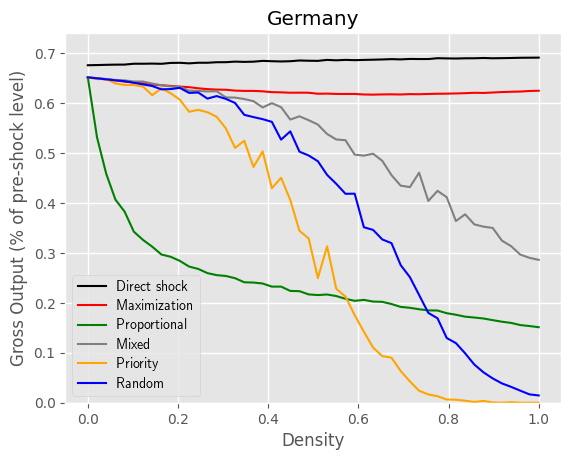

In [30]:
plt.style.use('ggplot')
plt.title("Germany")
plt.grid(visible=None, which='major', axis='both', linestyle='-', linewidth=1)

plt.plot(densseq, resdir_x, 'black')
plt.plot(densseq, resmax_x, 'red')
plt.plot(densseq, resprop_x, 'green')
plt.plot(densseq, resmixed_x, 'grey')
plt.plot(densseq, resprior_x, 'orange')
plt.plot(densseq, resrandom_x, 'blue')


#plt.xlim(-0.05, 1) 
plt.ylim(-0.00,0.74)
plt.rcParams['text.usetex'] = True
plt.xlabel('Density')
plt.ylabel("Gross Output (% of pre-shock level)")
plt.legend(['Direct shock', 'Maximization', 'Proportional', 'Mixed', 'Priority', 'Random'])
plt.savefig('plot_germany_density.png')